### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
os.getcwd()
from glob import glob
import random
# import seaborn as sns
pd.set_option('display.max_colwidth', None)
import datetime

In [2]:
img_paths=[]
img_labels=[]
for i in glob('archive/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])

In [3]:
len(img_paths),len(img_labels)

(23000, 23000)

In [4]:
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
16081,archive/test_another/damage/-95.083028_30.017774.jpeg,damage
13877,archive/train_another/damage/-95.070089_29.831028000000003.jpeg,damage
12706,archive/train_another/damage/-93.987121_29.894658000000003.jpeg,damage
20208,archive/test_another/damage/-95.157131_30.021141999999998.jpeg,damage
14307,archive/test_another/no_damage/-95.223651_30.02079.jpeg,no_damage


In [5]:
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(data,test_size=0.25,random_state=0)
train_set.shape,test_set.shape

((17250, 2), (5750, 2))

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

train_gen = ImageDataGenerator(
        validation_split=0.1,
        rescale=1/255
        # rotation_range=10, # rotation
        # width_shift_range=0.2, # horizontal shift
        # height_shift_range=0.2, # vertical shift
        # zoom_range=0.2, # zoom
        # horizontal_flip=True, # horizontal flip
        # brightness_range=[0.2,1.2]
        ) # brightness)

test_gen = ImageDataGenerator(
    rescale=1/255
) # brightness)

data_train = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    batch_size=32,
    seed=2020
)

data_val = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    batch_size=32,
    seed=2020
)

data_test = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=32,
    seed=2020
)

Found 15525 validated image filenames belonging to 2 classes.
Found 1725 validated image filenames belonging to 2 classes.
Found 5750 validated image filenames belonging to 2 classes.


    Importing images

In [7]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_data:
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Randomized search application

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam


In [9]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import TensorBoard, EarlyStopping

def create_model_alexnet(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))
    # model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # model.optimizer.learning_rate = hp.Float('learning_rate', 1e-7, 1e-4, sampling='log')
    model.optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-7, 1e-6, 1e-5, 1e-4])

    return model


# Define the search space of hyperparameters
tuner_hp = HyperParameters()
tuner_hp.Choice('optimizer', values=['adam', 'sgd', "rmsprop"])
# tuner_hp.Float('learning_rate', 1e-7, 1e-4, sampling='log')
tuner_hp.Choice('learning_rate', values=[1e-7, 1e-6, 1e-5, 1e-4])

# Create the tuner object
tuner = RandomSearch(
    create_model_alexnet,
    hyperparameters=tuner_hp,
    objective='val_accuracy',
    max_trials=10,
    # executions_per_trial=3,
    overwrite = True,
    # directory='',
    project_name='my_project')

now = datetime.datetime.now()
log_dir = f"./logs_alexnet_{now.strftime('%Y.%m.%d_%H.%M')}"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=False)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=1, 
    mode = "max", 
    # start_from_epoch=2,
    min_delta=0.01
    )

# Run the search
tuner.search(data_train, 
             epochs=15, 
             validation_data = data_val, 
             callbacks=[tensorboard, early_stopping]
             )

2023-03-17 22:31:02.007636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-17 22:31:02.007919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
sgd               |?                 |optimizer
0.0001            |?                 |learning_rate

Epoch 1/15


2023-03-17 22:31:02.974470: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-17 22:31:03.465000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


486/486 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.7197

2023-03-17 22:32:09.556758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


486/486 [==============================] - 70s 141ms/step - loss: 0.6323 - accuracy: 0.7197 - val_loss: 0.6041 - val_accuracy: 0.6632
Epoch 2/15
486/486 [==============================] - 74s 153ms/step - loss: 0.4316 - accuracy: 0.8377 - val_loss: 0.4129 - val_accuracy: 0.7925
Epoch 3/15
486/486 [==============================] - 74s 153ms/step - loss: 0.3577 - accuracy: 0.8718 - val_loss: 0.3049 - val_accuracy: 0.8968
Epoch 4/15
146/486 [========>.....................] - ETA: 46s - loss: 0.3319 - accuracy: 0.8818

In [132]:
model=tuner.get_best_models()[0]

In [133]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
learning_rate = best_hyperparameters.get('learning_rate')
optimizer = best_hyperparameters.get('optimizer')
print(f"Best learning rate: {learning_rate}")
print(f"Best optimizer: {optimizer}")

Best learning rate: 1e-06
Best optimizer: sgd


In [134]:
model.evaluate(data_test)

2023-03-17 13:30:52.413570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 4s 18ms/step - loss: 0.7029 - accuracy: 0.5000


[0.7029047012329102, 0.5]

In [105]:
model

In [106]:
import sklearn
from sklearn.metrics import confusion_matrix
y_pred = model.predict(data_test)
y_proba = [i[1] for i in y_pred]
y_pred_bin = np.argmax(y_pred,axis=1)


  4/180 [..............................] - ETA: 3s 

2023-03-16 16:43:44.589672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 3s 15ms/step


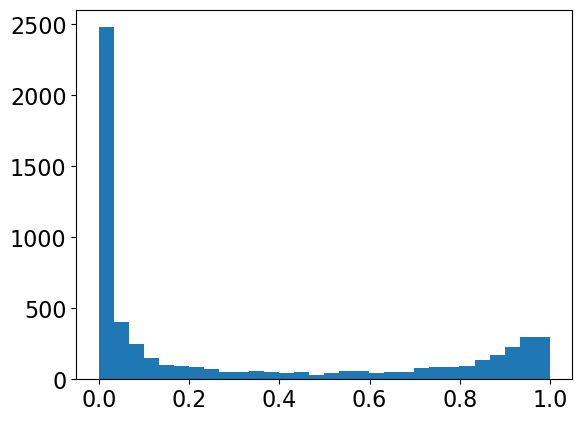

In [107]:
# Plot a histogram
plt.hist(y_proba, bins=30)
plt.show()

In [131]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(data_test.labels,y_pred))

classes=['Damage','No Damage']
con_mat_df = pd.DataFrame(confusion_matrix(data_test.labels,y_pred),
                     index = classes, 
                     columns = classes)


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

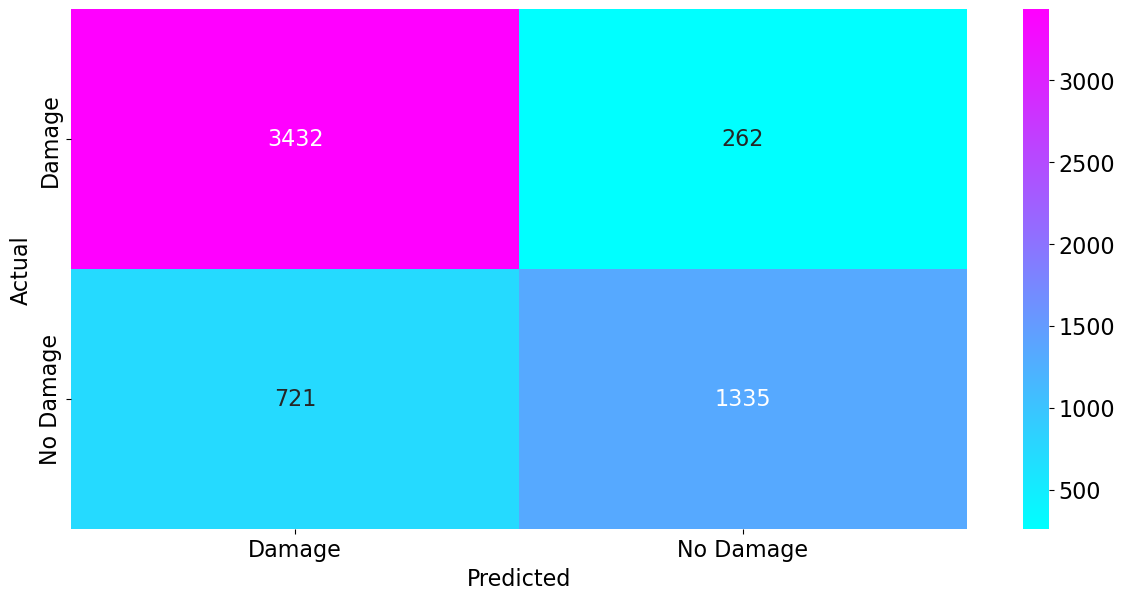

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [110]:

#### Evaluation functions for binary classification problems

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score)
from sklearn import metrics
import sklearn.metrics as metrics
from datetime import datetime #  time checking
import warnings
from sklearn import metrics
import sklearn.metrics as metrics

warnings.simplefilter(action='ignore', category=FutureWarning)

# calculate the fpr and tpr for all thresholds of the classification


def plot_roc_auc_curve(y_test, y_proba, y_pred_bin):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    """
    Plots the Receiver Operating Characteristic (ROC) curve for binary classification models.

    Parameters:
    y_test (array-like): True binary labels for the test set.
    y_proba (array-like): Predicted probabilities for the positive class.
    y_pred_bin (array-like): Predicted binary labels.
    valid_score (float): Valid ROC AUC score.

    Returns:
    None
    """

    # Calculate false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)

    # Calculate area under the ROC curve
    roc_auc = metrics.auc(fpr, tpr)

    # Calculate ROC AUC score for y_test and y_pred_bin
    valid_score = metrics.roc_auc_score(y_test, y_pred_bin)

    # Clear current plot
    plt.clf()

    # Set plot size and font size
    plt.figure(figsize=(12, 12))
    font = {'size': 16}
    plt.rc('font', **font)

    # Set plot title and plot ROC curve
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % valid_score)
    # Set plot legend and plot diagonal line
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    # Set plot axis limits and labels
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.show()


import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(y_label, y_proba_pred):
    """
    Plots the Precision-Recall curve for a binary classifier.

    Parameters:
        y_label (pandas Series): True binary labels of the test set
        y_proba_pred (array-like): Predicted probabilities of the test set

    Returns:
        Shows the plot
    """

    # Calculate precision, recall and threshold using the scikit-learn library
    precision, recall, threshold = precision_recall_curve(y_label.values, y_proba_pred)

    # Create a new figure for the plot
    plt.clf()
    plt.figure(figsize=(12,12))

    # Set the title and axis labels for the plot
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Sensitivity', fontsize=16)

    # Set the limits for the axis
    plt.axis([-0.01,1,0,1])
    # Plot the Precision-Recall curve using blue line
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.tight_layout()
    plt.show()
    # Uncomment the below line to save the plot
    # plt.savefig(path +"\\..\\Modelling"+ '\\Precision recall curve.png')


# Creating a function to report confusion metrics
def confusion_metrics(conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')



#%% Model training and evaluation
import pandas as pd
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def model_evaluation(model, X_test, y_test, cutting_point=0.5, show_variables=False, show_params=False, plot_roc=False, plot_pr_curve=False):
    """
    Evaluate a binary classification model.
    Args:
        model: A trained binary classification model.
        X_test: The feature matrix of the test dataset.
        y_test: The target vector of the test dataset.
        cutting_point: The threshold used to binarize the predicted probabilities.
        show_variables: If True, show the variables used in the model.
        show_params: If True, show the parameters used to train the model.
        plot_roc: If True, plot the ROC curve.
        plot_pr_curve: If True, plot the Precision-Recall curve.

    Returns:
        A tuple containing the predicted probabilities, the binarized predictions, and the validation AUC score.
    """

    # Print separator
    print(10 * "_____________")

    # Show variables used in the model if requested
    if show_variables:
        print("Variables used in the model:", X_test.columns)

    # Show parameters used to train the model if requested
    if show_params:
        print("Parameters used to train the model:", model.get_params)

    # Get predicted probabilities and binarize predictions based on the cutting point
    y_proba = model.predict(X_test).tolist()
    y_pred = model.predict(X_test).tolist()
    y_pred_bin = y_pred
    for i in range(len(y_proba)):
        if y_pred[i][0] >= cutting_point:
            y_pred_bin[i] = 1
        else:
            y_pred_bin[i] = 0

    # Get the current time for model evaluation
    modelling_hour = datetime.now()

    # Print model evaluation metrics
    print("Model executed at:\n", modelling_hour)
    print("Cutting point:", cutting_point)
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_bin)))
    valid_score = metrics.roc_auc_score(y_test, y_pred_bin)
    print(f"Validation AUC score: {valid_score}")

    # Plot ROC curve if requested
    if plot_roc:
        plot_roc_auc_curve(y_test, y_proba, valid_score)

    # Plot Precision-Recall curve if requested
    if plot_pr_curve:
        plot_pr_curve(y_test, y_proba)

    # Compute and print confusion matrix and other classification metrics
    cm = confusion_matrix(y_test, y_pred_bin)
    cm_df = pd.DataFrame(cm,
                        columns=['Predicted Negative', 'Predicted Positive'],
                        index=['Actual Negative', 'Actual Positive'])
    print(cm_df)
    confusion_metrics(cm)
    report = classification_report(y_test, y_pred_bin, target_names=['is_not_attributed', 'is_attributed'])
    print(report)

    # Return predicted probabilities, binarized predictions, and validation AUC score
    return y_proba, y_pred_bin, valid_score


<Figure size 640x480 with 0 Axes>

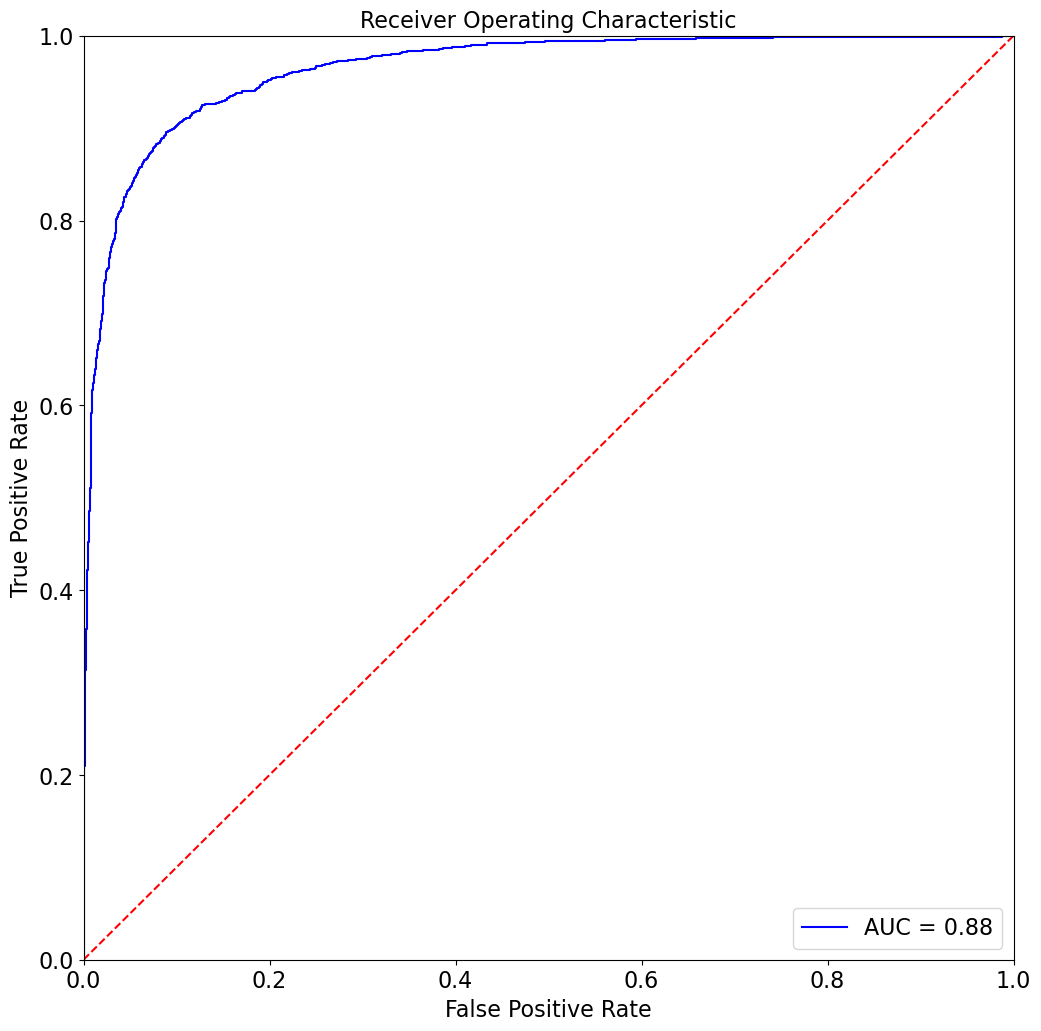

In [111]:
plot_roc_auc_curve(data_test.labels, y_proba, y_pred_bin)

In [86]:
con_mat_df.to_numpy()
confusion_metrics(con_mat_df.to_numpy())

True Positives: 1335
True Negatives: 3432
False Positives: 262
False Negatives: 721
--------------------------------------------------
Accuracy: 0.83
Mis-Classification: 0.17
Sensitivity: 0.65
Specificity: 0.93
Precision: 0.84
f_1 Score: 0.73


In [89]:
plot_pr_curve(data_test.labels, y_proba)

AttributeError: 'list' object has no attribute 'values'

### VGGM

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = (128, 128, 3)

# create the base model from the pre-trained model VGG16
# note that, if using a Kaggle server, internet has to be turned on
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base
pretrained_model.trainable = False

In [10]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [11]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import TensorBoard, EarlyStopping


def create_model_vgg16(hp):
    model = Sequential()
    model.add(VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    model.optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-7, 1e-6, 1e-5, 1e-4])

    return model

# Define the search space of hyperparameters
tuner_hp = HyperParameters()
tuner_hp.Choice('optimizer', values=['adam', 'sgd'])
# tuner_hp.Float('learning_rate', 1e-7, 1e-4, sampling='log')
tuner_hp.Choice('learning_rate', values=[1e-7, 1e-6, 1e-5, 1e-4])

# Create the tuner object
tuner = RandomSearch(
    create_model_vgg16,
    hyperparameters=tuner_hp,
    objective='val_accuracy',
    max_trials=8,
    # executions_per_trial=3,
    overwrite = True,
    # directory='',
    project_name='my_project')


now = datetime.datetime.now()
log_dir = f"./logs_vgg16_{now.strftime('%Y.%m.%d_%H.%M')}"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=False)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=1, 
    mode = "max", 
    # start_from_epoch=2,
    min_delta=0.005
    )

# Run the search
tuner.search(data_train, 
             epochs=6, 
             validation_data = data_val, 
             callbacks=[tensorboard, early_stopping]
             )

Trial 2 Complete [01h 44m 54s]
val_accuracy: 0.7026087045669556

Best val_accuracy So Far: 0.7026087045669556
Total elapsed time: 01h 54m 18s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
sgd               |sgd               |optimizer
0.0001            |1e-05             |learning_rate

Epoch 1/6


2023-03-17 20:43:33.065122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


486/486 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.6158

2023-03-17 20:55:45.293521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


486/486 [==============================] - 756s 2s/step - loss: 0.6695 - accuracy: 0.6158 - val_loss: 0.6389 - val_accuracy: 0.6730
Epoch 2/6
486/486 [==============================] - 842s 2s/step - loss: 0.6099 - accuracy: 0.6890 - val_loss: 0.5711 - val_accuracy: 0.7542
Epoch 3/6
253/486 [==============>...............] - ETA: 9:06 - loss: 0.5447 - accuracy: 0.7987